# CAPTCHA - ORC
    author: Oleg Naidovich
    
Работа будет оцениваться по следующим критериям:
1. Качество кода
2. Качество реализованного подхода
3. Качество описания принимаемых решений и анализа ошибок
4. Финальные метрики

# 1. Подготовка данных 
```
Нужно реализовать класс данных (наследник torch.utils.data.Dataset). Класс должен считывать входные изображения и выделять метки из имён файлов. Для чтения изображений предлагается использовать библиотеку Pillow. Дирректория содержит набор данных, который необходимо разделить на тренировочную и тестовую выборки в отношении четыре к одному.

```

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import transforms
from torchmetrics import CharErrorRate
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from IPython import display

from PIL import Image

In [27]:
class MyDataset(Dataset):
    def __init__(self, data_dir, image_names, token_to_id):
        self.data_dir = data_dir
        self.image_names = image_names
        self.token_to_id = token_to_id

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_fp = os.path.join(self.data_dir, image_name)
        image = Image.open(image_fp).convert('RGB')
        
        image = self.image_transform(image)
        image_name = self.txt_transform(image_name)
        return image, image_name
    
    def image_transform(self, image):
        image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(),
            transforms.Normalize((0.5, ), (0.5, ))])
        return image_transform(image)

    def txt_transform(self, image_txt):
        image_txt = image_txt.split(".")[0]
        return [self.token_to_id[letter] for letter in image_txt]

In [28]:
def get_tokens(image_names):
    boot = ''
    for name in image_names:
        boot += name.split('.')[0]
    return set(boot)

In [29]:
data_path = 'data/'

image_names = os.listdir(data_path)
image_names.remove('samples')
tokens = get_tokens(image_names)

token_to_id = {token: idx for idx, token in enumerate(tokens)}
id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))


def decode_label(idx):
    return ''.join([id_to_token[int(id_)] for id_ in idx])


def get_train_test_loaders(data_path, image_names, batch_size, test_size=0.25):
    image_names_train, image_names_test = train_test_split(image_names, 
                                                           test_size=test_size, 
                                                           random_state=42)

    train_dataset = MyDataset(data_path, image_names_train, token_to_id) 
    test_dataset = MyDataset(data_path, image_names_test, token_to_id)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [30]:
batch_size = 8
test_size = 0.25

train_loader, test_loader = get_train_test_loaders(data_path, image_names, 
                                                   batch_size, test_size)

In [31]:
img_batch, text_batch = next(iter(train_loader))

In [32]:
print(f'{len(train_loader) = }')
print(f'{len(test_loader) = }')
print(f'{img_batch.shape = }')

len(train_loader) = 101
len(test_loader) = 34
img_batch.shape = torch.Size([8, 1, 50, 200])


In [33]:
id_to_token

{0: 'y',
 1: 'x',
 2: 'f',
 3: '8',
 4: '5',
 5: 'c',
 6: '4',
 7: 'w',
 8: '3',
 9: 'd',
 10: 'e',
 11: 'm',
 12: 'n',
 13: '6',
 14: '7',
 15: 'b',
 16: '2',
 17: 'g',
 18: 'p'}

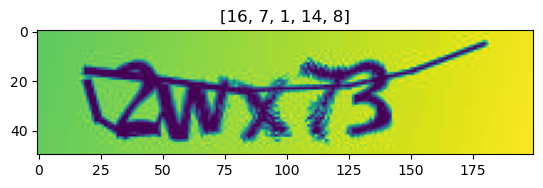

In [34]:
plt.title([int(tensor[0]) for tensor in text_batch])
plt.imshow(img_batch[0].numpy().transpose(1, 2, 0).squeeze())

# 2. Создание и обучение модели. 
    Код модели должен быть реализован через слои стандартной библиотеки torch (torchvision.models и аналоги использовать нельзя). Поскольку число символов в капче фиксировано, можно использовать обычный кросс- энтропийный критерий. Желающие могут использовать и CTC-loss. Цикл обучения можно реализовать самостоятельно или воспользоваться библиотеками PyTorch Lightning / Catalyst.

## Initialize model

In [35]:
device = torch.device('cude') if torch.cuda.is_available() else torch.device('cpu')

In [43]:
class CNN_Embeddings(nn.Module):
    def __init__(self, emb_size, dropout=0.45):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=1),
                                   nn.MaxPool2d(kernel_size=2, padding=[1, 1]),
                                   nn.BatchNorm2d(16), 
                                   nn.ReLU()) # 16x25x100
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=4, stride=1),
                                   nn.MaxPool2d(kernel_size=2, padding=[1, 0]),
                                   nn.BatchNorm2d(32), 
                                   nn.ReLU()) # 32x12x48
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1), 
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.BatchNorm2d(64), 
                                   nn.ReLU()) # 64x5x23
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=2, stride=1), 
                                   nn.MaxPool2d(kernel_size=4, padding=[1, 1]),
                                   nn.BatchNorm2d(128), 
                                   nn.ReLU()) # 128x1x6 = 768
        self.linear = nn.Sequential(nn.Linear(768, emb_size), 
                                    nn.ReLU()) # 768 -> emb_dim
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, imgs):
        out = self.conv1(imgs)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.dropout(out)
        out = self.conv3(out)
        out = self.dropout(out)
        out = self.conv4(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        out = self.dropout(out)
        return out


In [44]:
class NN_logits(nn.Module):
    def __init__(self, emb_size, n_tokens):
        super().__init__()
        self.linear0 = nn.Linear(emb_size, n_tokens)
        self.linear1 = nn.Linear(emb_size, n_tokens)
        self.linear2 = nn.Linear(emb_size, n_tokens)
        self.linear3 = nn.Linear(emb_size, n_tokens)
        self.linear4 = nn.Linear(emb_size, n_tokens)
    
    def forward(self, emb):
        return (self.linear0(emb), self.linear1(emb), 
                self.linear2(emb), self.linear3(emb), 
                self.linear4(emb))

In [45]:
class CaptchaSolver(nn.Module):
    def __init__(self, nn_Embeddings, nn_logits):
        super().__init__()
        self.nn_Embeddings = nn_Embeddings
        self.nn_logits = nn_logits
        
    def forward(self, images):
        embeddings = self.nn_Embeddings(images)
        logits = self.nn_logits(embeddings)
        return logits

In [46]:
n_epochs = 150
n_tokens = len(tokens)
emb_size = 512
lr = 0.003

model = CaptchaSolver(nn_Embeddings=CNN_Embeddings(emb_size), 
                       nn_logits=NN_logits(emb_size, n_tokens)).to(device)

criterion = nn.CrossEntropyLoss()
metric = CharErrorRate()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

summary(model, (1, 50, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 48, 198]             160
         MaxPool2d-2          [-1, 16, 25, 100]               0
       BatchNorm2d-3          [-1, 16, 25, 100]              32
              ReLU-4          [-1, 16, 25, 100]               0
           Dropout-5          [-1, 16, 25, 100]               0
            Conv2d-6           [-1, 32, 22, 97]           8,224
         MaxPool2d-7           [-1, 32, 12, 48]               0
       BatchNorm2d-8           [-1, 32, 12, 48]              64
              ReLU-9           [-1, 32, 12, 48]               0
          Dropout-10           [-1, 32, 12, 48]               0
           Conv2d-11           [-1, 64, 10, 46]          18,496
        MaxPool2d-12            [-1, 64, 5, 23]               0
      BatchNorm2d-13            [-1, 64, 5, 23]             128
             ReLU-14            [-1, 64

In [47]:
training_scores = {
    'Epoch': list(),
    'Train_Loss': list(),
    'Valid_Loss': list(),
    'Valid_Metric': list(),
}

('Epoch 150', 'Train Loss: 8.30', 'Valid Loss: 8.63', 'Valid Metric CER: 7.99%')


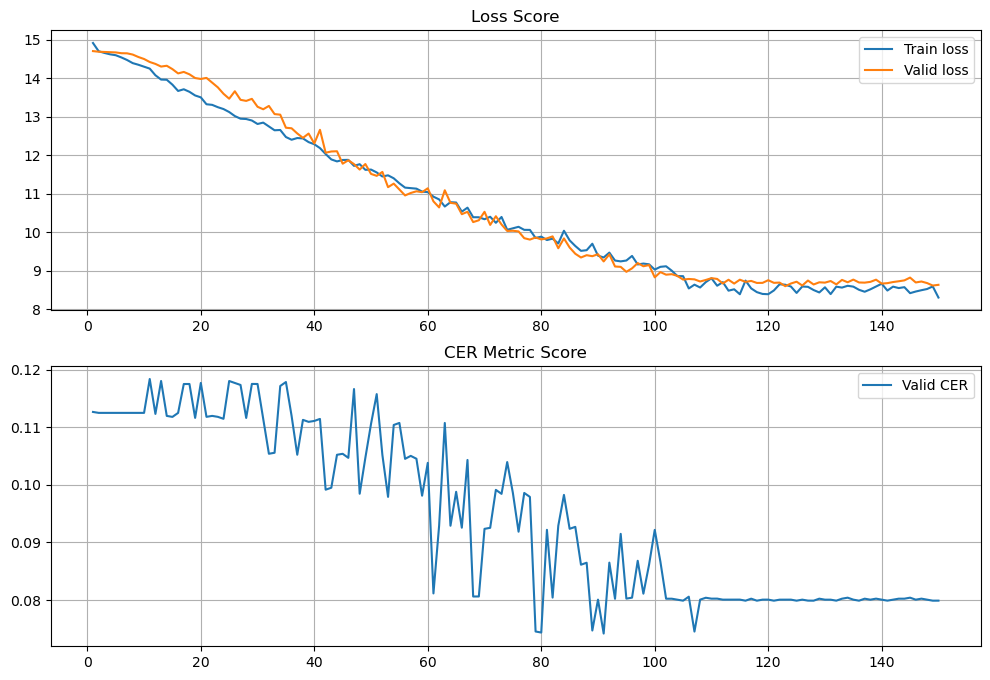

In [48]:
for epoch in range(1, n_epochs + 1):
    # Train
    model.train()
    epoch_train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = [label.to(device) for label in labels]

        pred_logits = model(images)

        loss = 0
        for idx in range(5):
            loss += criterion(pred_logits[idx], labels[idx])
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_loss += loss.item() / len(train_loader)
    
    # Validation
    model.train(False)
    epoch_val_loss = 0
    epoch_val_metric = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]

            pred_logits = model(images)
            pred_labels = [pred_logits[idx].max(dim=1)[1] for idx in range(5)]
            
            loss = 0
            for idx in range(5):
                loss += criterion(pred_logits[idx], labels[idx])
            epoch_val_loss += loss.item() / len(test_loader)

            for idx in range(images.size(0)):
                pred_label = decode_label([pred_labels[0][idx], pred_labels[1][idx], pred_labels[2][idx],
                                     pred_labels[3][idx], pred_labels[4][idx]])
                label = decode_label([labels[0][idx], labels[1][idx], labels[2][idx], 
                                labels[3][idx], labels[4][idx]])
                
                cer = float(metric(pred_label, label))
                epoch_val_metric += cer 
                
            epoch_val_metric /= len(test_loader)

    scheduler.step(epoch_val_metric)

    training_scores['Epoch'].append(epoch)
    training_scores['Train_Loss'].append(epoch_train_loss)
    training_scores['Valid_Loss'].append(epoch_val_loss)
    training_scores['Valid_Metric'].append(epoch_val_metric)

    # Report
    display.clear_output(wait=True)
    
    report = (f'Epoch {epoch}',
              f'Train Loss: {training_scores["Train_Loss"][-1]:.2f}', 
              f'Valid Loss: {training_scores["Valid_Loss"][-1]:.2f}',
              f'Valid Metric CER: {training_scores["Valid_Metric"][-1] * 100:.2f}%')
    print(report)

    fig, axis = plt.subplots(2, 1, figsize=(12, 8))
    axis[0].plot(training_scores["Epoch"], training_scores["Train_Loss"], label="Train loss")
    axis[0].plot(training_scores["Epoch"], training_scores["Valid_Loss"], label="Valid loss")
    axis[1].plot(training_scores["Epoch"], training_scores["Valid_Metric"], label="Valid CER")

    axis[0].set_title(f'Loss Score')
    axis[1].set_title(f'CER Metric Score')

    axis[0].legend()
    axis[1].legend()
    axis[0].grid()
    axis[1].grid()

    plt.show()

# 3. Подсчет метрик & Анализ ошибок модели. 
    После обучения нужно оценить точность предсказания на тестовой выборке. В качестве метрики предлагается использовать долю неверно распознанных символов, Character Error Rate (CER).
    
     найти изображения из тестового корпуса, на которых модель ошибается сильнее всего (по loss или по CER). Предлагается выписать в ноутбук возможные причины появления этих ошибок и пути устранения.

Best CER score: 7.42 at epoch 91



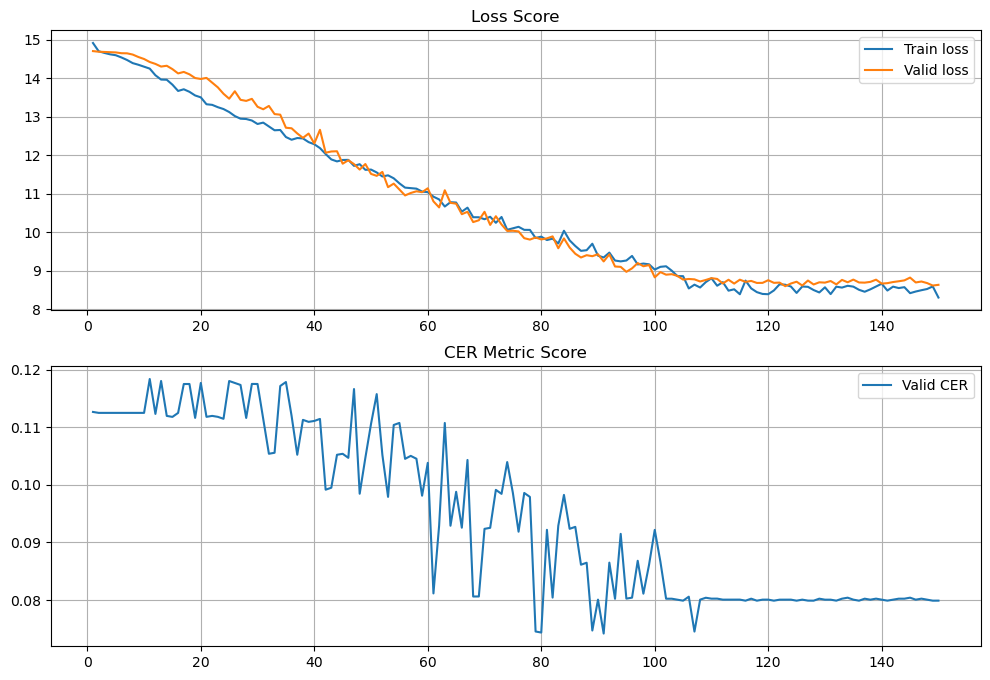

In [114]:
report = (f"Best CER score: {min(training_scores['Valid_Metric']) * 100:.2f} at epoch {np.argmin(training_scores['Valid_Metric']) + 1}\n")
print(report)

fig, axis = plt.subplots(2, 1, figsize=(12, 8))
axis[0].plot(training_scores["Epoch"], training_scores["Train_Loss"], label="Train loss")
axis[0].plot(training_scores["Epoch"], training_scores["Valid_Loss"], label="Valid loss")
axis[1].plot(training_scores["Epoch"], training_scores["Valid_Metric"], label="Valid CER")

axis[0].set_title(f'Loss Score')
axis[1].set_title(f'CER Metric Score')

axis[0].legend()
axis[1].legend()
axis[0].grid()
axis[1].grid()

In [106]:
model.eval()
hardest_cases = list()
N_worst = 13
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        
        pred_logits = model(images)
        pred_labels = [pred_logits[idx].max(dim=1)[1] for idx in range(5)]
        
        for idx in range(images.size(0)):
            pred_label = decode_label([pred_labels[0][idx], pred_labels[1][idx], pred_labels[2][idx],
                                       pred_labels[3][idx], pred_labels[4][idx]])
            label = decode_label([labels[0][idx], labels[1][idx], labels[2][idx], 
                                  labels[3][idx], labels[4][idx]])
            
            cer = float(metric(pred_label, label))
            hardest_cases.append([cer, pred_label, label])

In [107]:
hardest_cases.sort(key=lambda tup: tup[0])
hardest_cases = hardest_cases[-N:]

In [112]:
hardest_cases

[[0.4, '72n6d', '72m6f'],
 [0.4, 'ygg2c', 'yge7c'],
 [0.4, 'ydf2e', 'yd38e'],
 [0.4, '4ycyy', '4ycex'],
 [0.4, 'bennn', 'b5pnn'],
 [0.4, 'nf3nn', 'nf7bn'],
 [0.4, 'nf3nn', 'nf7bn'],
 [0.4, '77857', '77387'],
 [0.4, 'gnxnn', 'gpxng'],
 [0.4, '6xpnp', '6xpme'],
 [0.4, 'ngwcn', 'nwncn'],
 [0.4, 'dcxnp', 'dyxnc'],
 [0.4, 'b5mmn', 'b5nmm']]

# Вывод: 

Best CER score: 7.42 at epoch 91

Нашей модели хватило 91 эпох чтобы доучиться до качества 7.42, при этом имея 500к параметров. 

По результату выше видно, что модель ошибается особенно часто на следующих буквах: f/d/b, e/g, m/n/w. Из-за своех схожести, модели тяжело их отличить. Следовательно, для улучшения можели можно наполнить train выборку капчами, которые содержат данные буквы, также можно увеличить штраф, если эти буквы будут неправильно предсказываться.

Если смотреть в сторону улучшение модели через увеличение слоев свертки, то это может помочь, однако тогда придется дольше обучаться. Также можно рассмотреть другую архитекруту нейронной сети, например предстазывать капчу цельно, а не по буквам.

В baseline модели использовался **Dropout** для регуляризации, а также **BatchNorm** для выравнивания распределений между слоями.